In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-18 01:15:46.628576: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 01:15:46.628630: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df1 = pd.read_csv('../records_hour_30inst_1.csv', parse_dates=['interval_start'])
df1.drop(df1.columns[0], axis=1, inplace=True)
df1.rename(columns = {'interval_start':'date'}, inplace = True)
df1 = df1.groupby('date').sum()
df1 = df1.resample(rule='H').sum()
df1 = df1[1624:]

In [4]:
df2 = pd.read_csv('../records_hour_30inst_2.csv', parse_dates=['interval_start'])
df2.drop(df2.columns[0], axis=1, inplace=True)
df2.rename(columns = {'interval_start':'date'}, inplace = True)
df2 = df2.groupby('date').sum()
df2 = df2.resample(rule='H').sum()
df2 = df2[1624:]

In [5]:
df3 = pd.read_csv('../records_hour_30inst_3.csv', parse_dates=['interval_start'])
df3.drop(df3.columns[0], axis=1, inplace=True)
df3.rename(columns = {'interval_start':'date'}, inplace = True)
df3 = df3.groupby('date').sum()
df3 = df3.resample(rule='H').sum()
df3 = df3[1624:]

### Create batches of training data (12 months)

In [6]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit MLP model 

In [7]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(Dense(800, activation='relu', input_shape=(n_steps_in,)))
    model.add(Dense(800, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mae')
    model.fit(X, y, epochs=500, verbose=1, callbacks=[callback])
    return model 

In [8]:
def train_predict(train, test, actual):
    n_steps_in, n_steps_out, slide = 24, 6, 1
    X, y = split_sequence(train['count'].values.tolist(), n_steps_in, n_steps_out, slide)
    
    model = fit(X, y, n_steps_in, n_steps_out)
        
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_steps_in)) 
        pred = model.predict(x_input) 
        mae_aux, rmse_aux, smape_aux = measure_error(test, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
   
    return mae, rmse, smape

In [9]:
def sMAPE(Y_actual,Y_Predicted):
    smape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return smape

In [10]:
def measure_error(actual, pred, step_in, step_out, index):
    mae = mean_absolute_error(array([actual['count'][index+step_in:index+step_in+step_out]]), pred)
    rmse = np.sqrt(mean_squared_error(array([actual['count'][index+step_in:index+step_in+step_out]]), pred))
    smape = sMAPE(array([actual['count'][index+step_in:index+step_in+step_out]]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [11]:
train=df1[:500]
test=df1[500:]
mae1, rmse1, smape1 = train_predict(train, test, test)

2022-10-18 01:15:49.573237: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-18 01:15:49.573270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-18 01:15:49.573671: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
15/15 [==============================] - 1s 15ms/step - loss: 70.1626
Epoch 2/500
15/15 [==============================] - 0s 21ms/step - loss: 35.8884
Epoch 3/500
15/15 [==============================] - 0s 15ms/step - loss: 30.6341
Epoch 4/500
15/15 [==============================] - 0s 14ms/step - loss: 27.9333
Epoch 5/500
15/15 [==============================] - 0s 14ms/step - loss: 26.6591
Epoch 6/500
15/15 [==============================] - 0s 10ms/step - loss: 26.2929
Epoch 7/500
15/15 [==============================] - 0s 9ms/step - loss: 26.1828
Epoch 8/500
15/15 [==============================] - 0s 13ms/step - loss: 26.0292
Epoch 9/500
15/15 [==============================] - 0s 12ms/step - loss: 24.3383
Epoch 10/500
15/15 [==============================] - 0s 9ms/step - loss: 24.1891
Epoch 11/500
15/15 [==============================] - 0s 10ms/step - loss: 24.4147
Epoch 12/500
15/15 [==============================] - 0s 9ms/step - loss: 23.9907
Epoch 13/500
15/

15/15 [==============================] - 0s 9ms/step - loss: 13.8558
Epoch 198/500
15/15 [==============================] - 0s 9ms/step - loss: 12.9954
Epoch 199/500
15/15 [==============================] - 0s 10ms/step - loss: 12.5107
Epoch 200/500
15/15 [==============================] - 0s 10ms/step - loss: 12.4855
Epoch 201/500
15/15 [==============================] - 0s 9ms/step - loss: 12.7761
Epoch 202/500
15/15 [==============================] - 0s 10ms/step - loss: 13.0274
Epoch 203/500
15/15 [==============================] - 0s 10ms/step - loss: 12.7356
Epoch 204/500
15/15 [==============================] - 0s 11ms/step - loss: 13.0175
Epoch 205/500
15/15 [==============================] - 0s 11ms/step - loss: 12.4838
Epoch 206/500
15/15 [==============================] - 0s 14ms/step - loss: 13.0697
Epoch 207/500
15/15 [==============================] - 0s 19ms/step - loss: 13.0063
Epoch 208/500
15/15 [==============================] - 0s 16ms/step - loss: 12.8734
Epoch 209

15/15 [==============================] - 0s 9ms/step - loss: 9.6037
Epoch 393/500
15/15 [==============================] - 0s 10ms/step - loss: 10.3105
Epoch 394/500
15/15 [==============================] - 0s 10ms/step - loss: 10.6257
Epoch 395/500
15/15 [==============================] - 0s 15ms/step - loss: 9.9416
Epoch 396/500
15/15 [==============================] - 0s 15ms/step - loss: 9.5078
Epoch 397/500
15/15 [==============================] - 0s 10ms/step - loss: 9.7314
Epoch 398/500
15/15 [==============================] - 0s 9ms/step - loss: 9.6486
Epoch 399/500
15/15 [==============================] - 0s 10ms/step - loss: 9.6983
Epoch 400/500
15/15 [==============================] - 0s 13ms/step - loss: 9.4984
Epoch 401/500
15/15 [==============================] - 0s 11ms/step - loss: 9.5046
Epoch 402/500
15/15 [==============================] - 0s 10ms/step - loss: 9.1998
Epoch 403/500
15/15 [==============================] - 0s 14ms/step - loss: 9.1065
Epoch 404/500
15/1

15/15 [==============================] - 0s 21ms/step - loss: 8.3179
Epoch 492/500
15/15 [==============================] - 0s 20ms/step - loss: 8.2251
Epoch 493/500
15/15 [==============================] - 0s 12ms/step - loss: 8.4511
Epoch 494/500
15/15 [==============================] - 0s 13ms/step - loss: 8.3940
Epoch 495/500
15/15 [==============================] - 0s 12ms/step - loss: 8.0660
Epoch 496/500
15/15 [==============================] - 0s 12ms/step - loss: 8.4391
Epoch 497/500
15/15 [==============================] - 0s 12ms/step - loss: 8.3269
Epoch 498/500
15/15 [==============================] - 0s 12ms/step - loss: 8.1724
Epoch 499/500
15/15 [==============================] - 0s 12ms/step - loss: 8.0886
Epoch 500/500
15/15 [==============================] - 0s 13ms/step - loss: 8.2453


In [12]:
train=df2[:500]
test=df2[500:]
mae2, rmse2, smape2 = train_predict(train, test, test)

Epoch 1/500
15/15 [==============================] - 1s 11ms/step - loss: 69.1900
Epoch 2/500
15/15 [==============================] - 0s 15ms/step - loss: 37.5805
Epoch 3/500
15/15 [==============================] - 0s 15ms/step - loss: 32.5740
Epoch 4/500
15/15 [==============================] - 0s 12ms/step - loss: 30.0386
Epoch 5/500
15/15 [==============================] - 0s 12ms/step - loss: 28.1607
Epoch 6/500
15/15 [==============================] - 0s 12ms/step - loss: 27.9893
Epoch 7/500
15/15 [==============================] - 0s 12ms/step - loss: 26.9495
Epoch 8/500
15/15 [==============================] - 0s 14ms/step - loss: 27.8953
Epoch 9/500
15/15 [==============================] - 0s 16ms/step - loss: 27.1497
Epoch 10/500
15/15 [==============================] - 0s 13ms/step - loss: 26.1214
Epoch 11/500
15/15 [==============================] - 0s 13ms/step - loss: 25.6337
Epoch 12/500
15/15 [==============================] - 0s 12ms/step - loss: 25.1711
Epoch 13/500


15/15 [==============================] - 0s 12ms/step - loss: 12.8274
Epoch 197/500
15/15 [==============================] - 0s 11ms/step - loss: 12.8527
Epoch 198/500
15/15 [==============================] - 0s 12ms/step - loss: 13.9360
Epoch 199/500
15/15 [==============================] - 0s 11ms/step - loss: 13.2689
Epoch 200/500
15/15 [==============================] - 0s 11ms/step - loss: 13.3342
Epoch 201/500
15/15 [==============================] - 0s 11ms/step - loss: 13.0534
Epoch 202/500
15/15 [==============================] - 0s 11ms/step - loss: 12.6120
Epoch 203/500
15/15 [==============================] - 0s 11ms/step - loss: 12.9318
Epoch 204/500
15/15 [==============================] - 0s 11ms/step - loss: 14.3000
Epoch 205/500
15/15 [==============================] - 0s 11ms/step - loss: 14.1676
Epoch 206/500
15/15 [==============================] - 0s 12ms/step - loss: 13.8013
Epoch 207/500
15/15 [==============================] - 0s 11ms/step - loss: 13.3199
Epoch 

15/15 [==============================] - 0s 12ms/step - loss: 10.0871
Epoch 391/500
15/15 [==============================] - 0s 11ms/step - loss: 9.7057
Epoch 392/500
15/15 [==============================] - 0s 11ms/step - loss: 10.0424
Epoch 393/500
15/15 [==============================] - 0s 11ms/step - loss: 9.5002
Epoch 394/500
15/15 [==============================] - 0s 11ms/step - loss: 9.5760
Epoch 395/500
15/15 [==============================] - 0s 12ms/step - loss: 9.2164
Epoch 396/500
15/15 [==============================] - 0s 11ms/step - loss: 9.3430
Epoch 397/500
15/15 [==============================] - 0s 12ms/step - loss: 9.7345
Epoch 398/500
15/15 [==============================] - 0s 12ms/step - loss: 11.1609
Epoch 399/500
15/15 [==============================] - 0s 11ms/step - loss: 10.5606
Epoch 400/500
15/15 [==============================] - 0s 12ms/step - loss: 9.5043
Epoch 401/500
15/15 [==============================] - 0s 11ms/step - loss: 9.4795
Epoch 402/500


In [13]:
train=df3[:500]
test=df3[500:]
mae3, rmse3, smape3 = train_predict(train, test, test)

Epoch 1/500
15/15 [==============================] - 1s 13ms/step - loss: 70.2522
Epoch 2/500
15/15 [==============================] - 0s 14ms/step - loss: 36.1982
Epoch 3/500
15/15 [==============================] - 0s 12ms/step - loss: 30.7896
Epoch 4/500
15/15 [==============================] - 0s 13ms/step - loss: 29.0615
Epoch 5/500
15/15 [==============================] - 0s 12ms/step - loss: 28.6272
Epoch 6/500
15/15 [==============================] - 0s 13ms/step - loss: 26.7133
Epoch 7/500
15/15 [==============================] - 0s 12ms/step - loss: 26.6316
Epoch 8/500
15/15 [==============================] - 0s 11ms/step - loss: 26.2426
Epoch 9/500
15/15 [==============================] - 0s 12ms/step - loss: 25.4949
Epoch 10/500
15/15 [==============================] - 0s 12ms/step - loss: 25.1095
Epoch 11/500
15/15 [==============================] - 0s 13ms/step - loss: 24.7444
Epoch 12/500
15/15 [==============================] - 0s 12ms/step - loss: 24.6710
Epoch 13/500


15/15 [==============================] - 0s 12ms/step - loss: 13.6621
Epoch 197/500
15/15 [==============================] - 0s 11ms/step - loss: 13.5344
Epoch 198/500
15/15 [==============================] - 0s 11ms/step - loss: 13.8683
Epoch 199/500
15/15 [==============================] - 0s 11ms/step - loss: 13.2977
Epoch 200/500
15/15 [==============================] - 0s 11ms/step - loss: 13.8553
Epoch 201/500
15/15 [==============================] - 0s 12ms/step - loss: 13.6711
Epoch 202/500
15/15 [==============================] - 0s 12ms/step - loss: 13.6450
Epoch 203/500
15/15 [==============================] - 0s 12ms/step - loss: 13.3637
Epoch 204/500
15/15 [==============================] - 0s 13ms/step - loss: 13.2134
Epoch 205/500
15/15 [==============================] - 0s 11ms/step - loss: 13.5829
Epoch 206/500
15/15 [==============================] - 0s 12ms/step - loss: 13.4143
Epoch 207/500
15/15 [==============================] - 0s 11ms/step - loss: 13.3418
Epoch 

15/15 [==============================] - 0s 11ms/step - loss: 11.3388
Epoch 391/500
15/15 [==============================] - 0s 11ms/step - loss: 11.9457
Epoch 392/500
15/15 [==============================] - 0s 11ms/step - loss: 11.0720
Epoch 393/500
15/15 [==============================] - 0s 12ms/step - loss: 11.4135
Epoch 394/500
15/15 [==============================] - 0s 11ms/step - loss: 11.2803
Epoch 395/500
15/15 [==============================] - 0s 12ms/step - loss: 10.9466
Epoch 396/500
15/15 [==============================] - 0s 11ms/step - loss: 11.0064
Epoch 397/500
15/15 [==============================] - 0s 11ms/step - loss: 10.8736
Epoch 398/500
15/15 [==============================] - 0s 12ms/step - loss: 10.9303
Epoch 399/500
15/15 [==============================] - 0s 11ms/step - loss: 10.7826
Epoch 400/500
15/15 [==============================] - 0s 11ms/step - loss: 10.4754
Epoch 401/500
15/15 [==============================] - 0s 11ms/step - loss: 11.0760
Epoch 

### Calculate Error

In [14]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

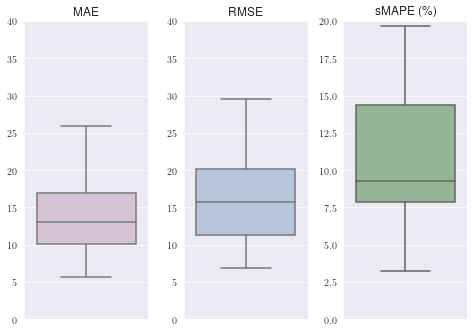

In [15]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 40))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 40))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 20))
plt.tight_layout()
#plt.savefig('figures/emergencies_MLP_hourly_boxplot.pdf')

In [17]:
emer_mlp_hour = [mae,rmse,smape]
%store emer_mlp_hour

Stored 'emer_mlp_hour' (list)
